Offer Response Classes

0 - user did not make any purchase due to sent offers

1 - user completed offer due to sent offer

2 - user completed offer by chance (without viewing)

3 - user made purchase due to information

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
X_df = pd.read_csv("data/processed/data.csv")
y_df = pd.read_csv("data/processed/target.csv")
del X_df["Unnamed: 0"]
del y_df["Unnamed: 0"]

In [3]:
X_df.head()

,user_id,offer_id,completion_time,reward,duration,difficulty,gender_F,gender_M,gender_O,age,income,became_member_year,total_amt
0,13,3,0,0,96,0,0,1,0,58,51000.0,2017,0.87
1,23,3,0,0,96,0,1,0,0,78,71000.0,2017,18.98
2,49,8,0,0,72,0,0,1,0,39,51000.0,2014,1.63
3,67,8,18,0,72,0,0,1,0,75,52000.0,2015,6.86
4,83,8,0,0,72,0,0,1,0,27,35000.0,2018,3.62


In [4]:
y_df.head()

,offer_response
0,0
1,3
2,0
3,3
4,3


In [5]:
# split into test train data
def split_train_test_data(X, Y, test_size=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=42)
    return (X_train, X_test, Y_train, Y_test)

In [6]:
def build_model(clf, parameters=None, scoring=None):
    pipeline = Pipeline([
            ('scaler', StandardScaler(copy=False)),
            ('pca', PCA()),
            ('clf', clf),
        ])
    # define parameters for grid search
    param_grid = {
        'pca__n_components': [8, 10, 12],
    }
    
    if parameters is not None:
        for key in parameters.keys():
            param_grid[key] = parameters[key]
    
    # grid search object
    return GridSearchCV(pipeline, param_grid, n_jobs=-1, scoring=scoring)

## Logistic Regression

In [7]:
X_train, X_test, Y_train, Y_test =  split_train_test_data(X_df, y_df, test_size=0.2)

In [8]:
clf = LogisticRegression(max_iter=15000, tol=0.001)
parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__class_weight': [None, "balanced"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters, "balanced_accuracy")
# model.fit(X_train, Y_train.values.ravel())


# load from saved model
modelFile = "models/logistic_regression_1.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__class_weight': 'balanced', 'clf__penalty': 'none', 'pca__n_components': 12}


In [9]:
def evaluate_model(X_test, Y_test, model):
    y_pred = model.predict(X_test)
    # calculate performance metrics
    print(classification_report(Y_test.values.ravel(), y_pred))
    # calculate confusion matric
    print("Confusion Matrix")
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])
    disp.plot()
    plt.show()

              precision    recall  f1-score   support

           0       0.83      0.54      0.65      8010
           1       0.66      0.78      0.71      4003
           2       1.00      1.00      1.00      2784
           3       0.31      0.98      0.47       957

    accuracy                           0.71     15754
   macro avg       0.70      0.83      0.71     15754
weighted avg       0.78      0.71      0.72     15754

Confusion Matrix


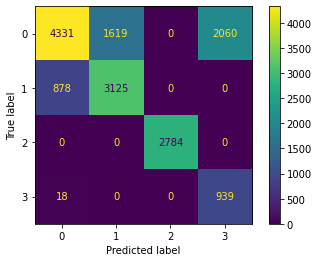

In [10]:
evaluate_model(X_test, Y_test, model)

In [11]:
def save_model(model, model_filepath):
    """
    Save the trained model to a file as pickle
    Args:
        - model: trained model to save
        - model_filepath: relative path (with filename) to save the model.
    """
    # save the model to disk
    pickle.dump(model, open(model_filepath, 'wb'))

In [12]:
save_model(model, modelFile)

Due to larger samples of class 0 1793 samples of class 1 data are predicted as class 0 and 454 samples of class 3 are classified as class 0.

## SMOTE for over sampling

In [13]:
# perform over_sampling with SMOTE
oversample = SMOTE()

print("Old data rows: ", X_df.shape[0])
X, Y = oversample.fit_resample(X_df, y_df)
print("New data rows:", X.shape[0])

Old data rows:  78770
New data rows: 158984


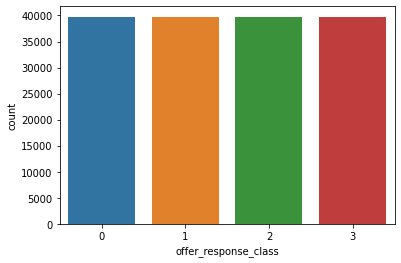

In [14]:
import seaborn as sns

response_counts = Y.offer_response.value_counts().reset_index()
ax = sns.barplot(x='index', y='offer_response', data=response_counts);
ax.set(xlabel="offer_response_class", ylabel="count");

**SMOTE** over-sampled the data and made equal data samples for all user response classes. One issue this could cause is the noise introduced into data due to over-sampling.

In [15]:
# split into test train data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
clf = LogisticRegression(max_iter=15000, tol=0.001)
parameters = {
    'clf__penalty': ['none', 'l2'],
    'clf__class_weight': [None, "balanced"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/logistic_regression.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__class_weight': None, 'clf__penalty': 'none', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.71      0.74      0.72      7878
           1       0.86      0.76      0.81      7896
           2       0.99      1.00      1.00      8055
           3       0.87      0.94      0.91      7968

    accuracy                           0.86     31797
   macro avg       0.86      0.86      0.86     31797
weighted avg       0.86      0.86      0.86     31797

Confusion Matrix


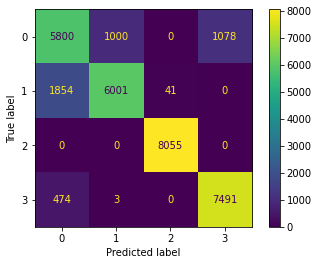

In [17]:
evaluate_model(X_test, Y_test, model)

In [18]:
save_model(model, modelFile)

We can still see lot of wrong predictions in class 0, class 1 and class 4, but using smote to upsample the data has helped improve all accuracy, precision and recall across all classes

## Decision Tree

In [19]:
clf = DecisionTreeClassifier()
parameters = {
    'pca__n_components': [12, ],
    'clf__max_depth': [None, 10, 15],
    'clf__max_features': ["auto", "log2"],
}

# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/decision_tree.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__max_depth': None, 'clf__max_features': 'log2', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7878
           1       0.87      0.86      0.87      7896
           2       0.96      0.96      0.96      8055
           3       0.95      0.95      0.95      7968

    accuracy                           0.91     31797
   macro avg       0.91      0.91      0.91     31797
weighted avg       0.91      0.91      0.91     31797

Confusion Matrix


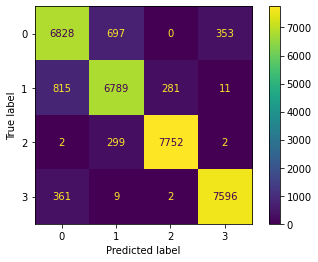

In [20]:
evaluate_model(X_test, Y_test, model)

In [21]:
save_model(model, modelFile)

## Naive Bayes

In [29]:
clf = GaussianNB()
parameters = {
    'pca__n_components': [12, ],
    'clf__var_smoothing': [0.0001, 0.0000001, 0.000000001],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/naive_bayes.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__var_smoothing': 0.0001, 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.60      0.48      0.53      7878
           1       0.67      0.65      0.66      7896
           2       0.93      0.95      0.94      8055
           3       0.81      0.97      0.88      7968

    accuracy                           0.76     31797
   macro avg       0.75      0.76      0.75     31797
weighted avg       0.75      0.76      0.75     31797

Confusion Matrix


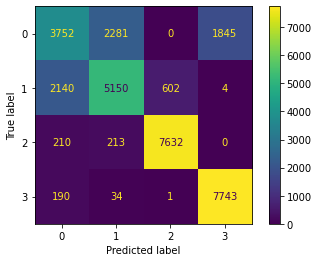

In [30]:
evaluate_model(X_test, Y_test, model)

In [31]:
save_model(model, modelFile)

## Gradient Boosting

In [35]:
clf = GradientBoostingClassifier(tol=0.001)
parameters = {
    'pca__n_components': [12, ],
    'clf__learning_rate': [0.1, 0.01],
    'clf__min_samples_leaf': [5, 10]
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/gradient_boosting.pkl"
model = pickle.load(open(modelFile, 'rb'))
print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__learning_rate': 0.1, 'clf__min_samples_leaf': 10, 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.83      0.82      0.83      7878
           1       0.89      0.84      0.86      7896
           2       0.97      1.00      0.98      8055
           3       0.93      0.96      0.94      7968

    accuracy                           0.90     31797
   macro avg       0.90      0.90      0.90     31797
weighted avg       0.90      0.90      0.90     31797

Confusion Matrix


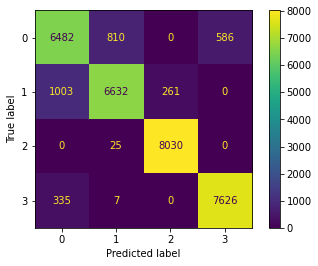

In [36]:
evaluate_model(X_test, Y_test, model)

In [37]:
save_model(model, modelFile)

## KNN

In [26]:
clf = KNeighborsClassifier()
parameters = {
    'pca__n_components': [12, ],
    'clf__n_neighbors': [4, 5, 6],
    'clf__weights': ["uniform", "distance"],
}
# uncomment below 2 lines for training
# model = build_model(clf, parameters)
# model.fit(X_train, Y_train.values.ravel())

# load from saved model
modelFile = "models/knn.pkl"
model = pickle.load(open(modelFile, 'rb'))

print("Best Parameters:")
print(model.best_params_)

Best Parameters:
{'clf__n_neighbors': 4, 'clf__weights': 'distance', 'pca__n_components': 12}


              precision    recall  f1-score   support

           0       0.79      0.83      0.81      7878
           1       0.89      0.80      0.84      7896
           2       0.97      0.99      0.98      8055
           3       0.93      0.95      0.94      7968

    accuracy                           0.89     31797
   macro avg       0.89      0.89      0.89     31797
weighted avg       0.90      0.89      0.89     31797

Confusion Matrix


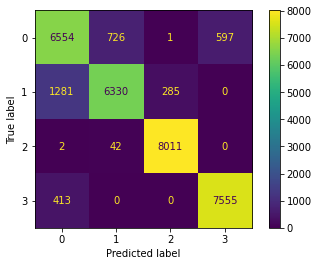

In [27]:
evaluate_model(X_test, Y_test, model)

In [28]:
save_model(model, modelFile)